In [1]:
import numpy as np
import matplotlib.pyplot as plt
import abc
from shapely.geometry import Polygon
import time
import networkx as nx
%matplotlib inline

In [2]:
class AbstractUDMIS(abc.ABC):
    @abc.abstractmethod
    def energy(self):
        """Returns the energy of the current Rydberg occupation configuration"""

    @abc.abstractmethod
    def energy_diff(self, *coords):
        """Returns the energy difference resulting from flipping the occupation at the given coordinates"""
        
    @abc.abstractmethod
    def rand_vertex(self):
        """Selects a site in the graph at random"""
    
    def mc_step(self, T):
        """Performs a full update of the Rydberg model using the Metropolis-Hastings algorithm"""
        current_energy = self.energy()
        for _ in range(self.num_vertices):
            vertex = self.rand_vertex()
            dE = self.energy_diff(vertex)
            
            if (dE < 0) or (np.random.rand() < np.exp(-dE / T)):
                current_energy += dE
                self.occupations[vertex] ^= 1 
                # flips occupation 0 --> 1 OR 1 --> 0

        return current_energy
    
    
    
    def mc_step_wolf(self, T):
        """Performs a full update of the Rydberg model using the Metropolis-Hastings algorithm"""
        current_energy = self.energy()
        for _ in range(self.num_vertices):
            vertex = self.rand_vertex()
            vertex2 = vertex - 2
            dE = self.energy_diff(vertex)

            if (dE < 0) or (np.random.rand() < np.exp(-dE / T)):
                current_energy += dE
                self.occupations[vertex] ^= 1 
                if (vertex > 2):
                    if (self.occupations[vertex] == 1) & ((self.occupations[vertex2] == 0)):
                        self.occupations[vertex2] == 1 
                    elif (self.occupations[vertex] == 0) & ((self.occupations[vertex2] == 1)):
                        self.occupations[vertex2] == 0

                # flips occupation 0 --> 1 OR 1 --> 0

        return current_energy

In [3]:
class UDMIS(AbstractUDMIS):
    def __init__(self, u, graph):
        super().__init__()
        self.u, self.graph = u, graph
        self.num_vertices = len(self.graph)
        print(self.num_vertices)
        # initialize system at infinite temperature
        # i.e. vertices are completely random and uncorrelated
        self.occupations = np.random.rand(self.num_vertices) < 0.5
        self.edges = self.find_edges()
    
    def find_edges(self):
        #num_pairs = int(self.num_vertices*(self.num_vertices)*0.5)
        edges = np.zeros((self.num_vertices, self.num_vertices), dtype=bool)
        
        for i in range(self.num_vertices-1):
            x_i, y_i = graph[i] # these are the x, y coordinates of the i'th vertex in the graph
            for j in range(i+1, self.num_vertices):
                x_j, y_j = graph[j] # these are the x, y coordinates of the j'th vertex in the graph
                
                # calculate the distance between vertices
                dij = np.sqrt((x_i - x_j)**2. + (y_i - y_j)**2.)
                if dij <= 1.0:
                    edges[i,j] = True
                    edges[j,i] = True
                    
        return edges
        
    def energy(self):
        """Returns the energy of the current spin configuration"""
        # interaction term
        interaction_term = 0
        vertex_term = 0
        for i in range(self.num_vertices-1):
            for j in range(i+1, self.num_vertices):
                
                # check if there is an edge
                if self.edges[i,j]:
                    interaction_term += self.occupations[i]*self.occupations[j]
                
            vertex_term += self.occupations[i]
        
        # missed the last vertex
        vertex_term += self.occupations[self.num_vertices-1]
    
        return u*interaction_term - vertex_term

    def energy_diff(self, i):
        connections = np.where(self.edges[i,:])[0]
        num_adjacent_occupied = sum(self.occupations[connections])
        
        if self.occupations[i] == 1:
            # flipping an occupied vertex increases the vertex term, decreases the interaction term
            vertex_term_change = 1.
            interaction_term_change = -u*num_adjacent_occupied
        
        elif self.occupations[i] == 0:
            # flipping an unoccupied vertex decreases the vertex term, increases the interaction term
            vertex_term_change = -1.
            interaction_term_change = u*num_adjacent_occupied 

        return interaction_term_change + vertex_term_change
    
    def rand_vertex(self):
        """Selects a site in the graph at random"""
        return np.random.randint(self.num_vertices)  

In [4]:
u = 2

graph = [(0.3461717838632017, 1.4984640297338632), 
         (0.6316400411846113, 2.5754677320579895), 
         (1.3906262250927481, 2.164978861396621), 
         (0.66436005100802, 0.6717919819739032), 
         (0.8663329771713457, 3.3876341010035995), 
         (1.1643107343501296, 1.0823066243402013)
        ]

udmis = UDMIS(u, graph)

6


In [5]:
# pgon = Polygon(zip([item[0] for item in graph], [item[1] for item in graph]))

# print(pgon.area)

In [6]:
N = 10000
t = np.arange(N+1)
T_i = 10000
T_f = 0.001

T = T_i * ((T_f/T_i) ** (t/N))

E_list = []

start_time = time.time()

for t in range(N):
    # take a look at the abstract_udmis.py file to see how mc_step works
    temp = T[t]
    
    E_list.append(udmis.mc_step(T=temp))

    if t > N*0.1:

        if t % 100 == 0:
            print(t, E_list[t], udmis.occupations)
            
            if (E_list[t] == E_list[t-1])&(E_list[t-1] == E_list[t-2])&(E_list[t] <= min(E_list)):
                #print(E_list)
                break
    
print("--- %s seconds ---" % (time.time() - start_time))

1100 -1.0 [False  True False False  True  True]
1200 -1.0 [False  True False False  True  True]
1300 -2.0 [False False  True  True False False]
1400 2.0 [ True False False  True  True  True]
1500 -2.0 [ True False False False  True False]
1600 0.0 [False  True False False  True False]
1700 -2.0 [False False  True False False  True]
1800 0.0 [ True  True  True False False  True]
1900 -1.0 [False False False  True False False]
2000 -1.0 [False False  True False False False]
2100 -1.0 [False  True  True  True False False]
2200 1.0 [False  True  True  True  True  True]
2300 -1.0 [False  True False  True False  True]
2400 -2.0 [False False  True  True False False]
2500 0.0 [False  True  True  True  True False]
2600 -1.0 [False False  True  True False  True]
2700 -2.0 [False False False False  True  True]
2800 -2.0 [False False  True False  True False]
2900 -2.0 [False False False  True  True False]
3000 -2.0 [ True False  True  True  True False]
3100 -2.0 [False False False False  True  Tru

In [7]:
N = 10000
t = np.arange(N+1)
T_i = 10000
T_f = 0.001

T = T_i * ((T_f/T_i) ** (t/N))

E_list2 = []

start_time = time.time()
for t in range(N):
    # take a look at the abstract_udmis.py file to see how mc_step works
    temp = T[t]
    
    E_list2.append(udmis.mc_step_wolf(T=temp))

    if t > N*0.1:

        if t % 100 == 0:
            print(t, E_list2[t], udmis.occupations)
            
            if (E_list2[t] == E_list2[t-1])&(E_list2[t-1] == E_list2[t-2])&(E_list2[t] <= min(E_list2)):
                #print(E_list)
                break
    
print("--- %s seconds ---" % (time.time() - start_time))

1100 -1.0 [ True  True  True False False False]
1200 0.0 [False  True  True  True  True False]
1300 -1.0 [False False  True False False False]
1400 -3.0 [False False  True  True  True False]
1500 -1.0 [False  True False  True False  True]
1600 -1.0 [False False False False False  True]
1700 1.0 [False  True  True False  True False]
1800 0.0 [False  True  True False False False]
1900 0.0 [ True False False False False  True]
2000 1.0 [ True  True  True False  True  True]
2100 -2.0 [ True  True False False False False]
2200 1.0 [False  True  True  True  True  True]
2300 -2.0 [False  True False  True False False]
2400 0.0 [ True  True  True False False  True]
2500 2.0 [ True False False  True  True  True]
2600 -2.0 [False  True False  True False False]
2700 -2.0 [ True False  True False False False]
2800 -2.0 [False  True False  True False False]
2900 -1.0 [False  True False  True  True False]
3000 -2.0 [ True  True False False False False]
3100 -1.0 [ True  True False False False  True]


In [8]:
plt.rcParams["figure.figsize"] = (13,6)

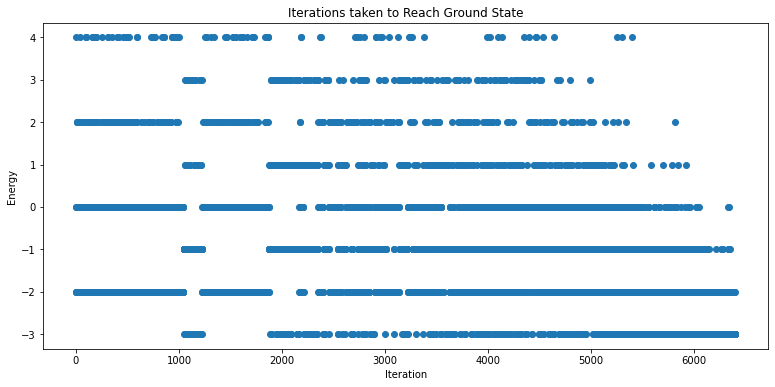

In [9]:
plt.scatter([i for i in range(len(E_list))], E_list)
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title("Iterations taken to Reach Ground State");

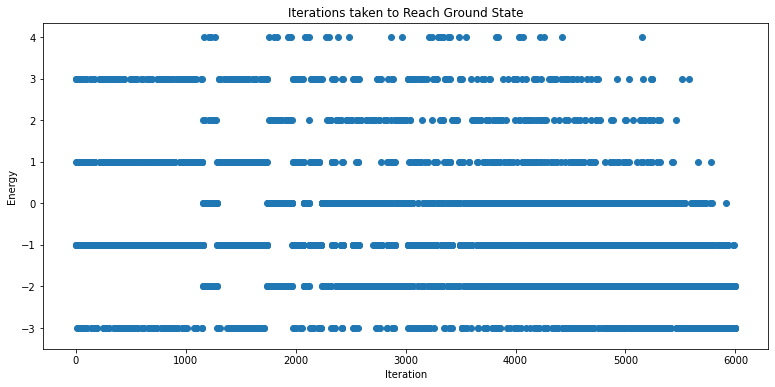

In [10]:
plt.scatter([i for i in range(len(E_list2))], E_list2)
plt.ylim(-3.5)
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title("Iterations taken to Reach Ground State");

In [11]:
def get_edges(graph):
    Nv = len(graph)
    edges = np.zeros((Nv, Nv))
    for i in range(Nv - 1):
        xi, yi = graph[i]
        for j in range(i + 1, Nv):
            xj, yj = graph[j]
            dij = np.sqrt((xi - xj) ** 2. + (yi - yj) ** 2.)
            if dij <= 1.0:
                edges[i, j] = 1
    return np.argwhere(edges == 1)

In [12]:
edges = get_edges(graph)
G = nx.Graph()
for edge in edges:
    G.add_edge(edge[0], edge[1])

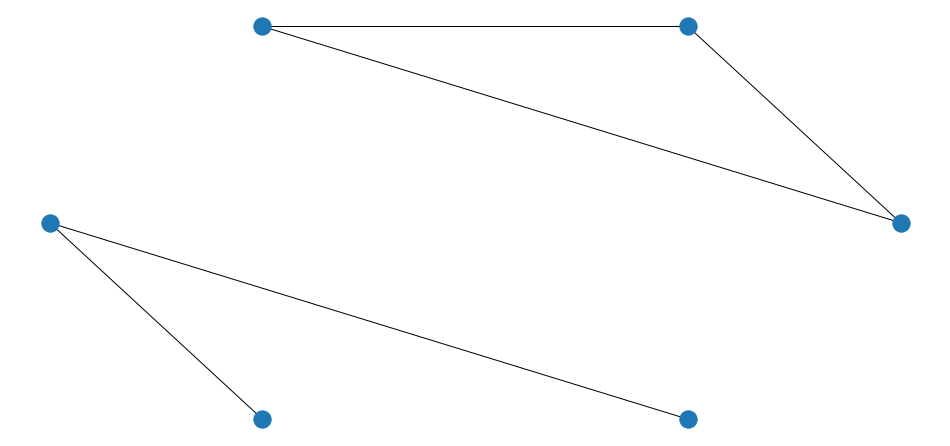

In [13]:
pos = nx.circular_layout(G)
nx.draw(G, pos=pos)